# FINM3422 Coding Project 2: OTC Derivatives Pricing & Hedging

This notebook implements an object-oriented solution to value four OTC derivative trades and calculate portfolio-level hedging parameters. All data and valuations including spot prices, volatilities and time to maturity is based on market data as of May 16. Each derivative is modelled using an appropriate valuation method (e.g. Black-Scholes) to reflect key financial principles. The project's requirements are met by combining Object Oriented programming with realistic market integration to achieve accurate pricing and risk assessment in a way that resembles real world trading and risk management practices.

## Imports and Setup

In [41]:
from Option_Classes import EuropeanOption
from Option_Classes import AmericanPutOption
from Option_Classes import UpAndInCallOption
from Option_Classes import BasketCallOption
from Hedging_Parameters import HedgingCalculator
from market_data import get_close_price
from market_data import get_volatility
from market_data import get_correlation_matrix
from market_data import get_all_market_data
import pandas as pd
from datetime import datetime, timedelta
import yfinance as yf
import importlib
from sensitivity_visualiser import plot_spot_vol_sensitivity, plot_spot_vol_sensitivity_barrier, plot_spot_vol_sensitivity_basket_bs
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from scipy.optimize import minimize
from bootstrap import BankBill, Bond, Portfolio, YieldCurve
from tree_visualiser import get_stock_and_option_trees, plot_binomial_tree_networkx

## Discount Curve Construction

do we build discount curve in the .ipynb file, or can we just produce the discount rates in the .py file? fix with the new discount curve file

In [42]:
def time_to_expiry(start, end):
    return (end - start).days / 365.0

# Bootstrap yield curve based off of bills and bonds
# Data extracted from bloomberg terminal and yields were interpolated to align with option maturities
if __name__ == "__main__":

    # 1 Month Bank Bill

    maturity_1m = 1 / 12  # 1 month = 1/12 year
    yield_1m = 3.7925 / 100
    price_1m = 100 * (1 - yield_1m * maturity_1m)  # ≈ 99.684

    bill1 = BankBill(face_value=100, maturity=1/12, price=99.684)
    bill1.set_cash_flows()

    # 3 Month Bank Bill

    maturity_3m = 0.25  # 3 months
    yield_3m = 3.7972 / 100
    price_3m = 100 * (1 - yield_3m * maturity_3m)  # ≈ 99.055

    bill2 = BankBill(face_value=100, maturity=0.25, price=99.055)
    bill2.set_cash_flows()

    # 6 Month Bank Bill

    maturity_6m = 0.5  # 6 months
    yield_6m = 3.8550 / 100
    price_6m = 100 * (1 - yield_6m * maturity_6m)  # ≈ 98.083

    bill3 = BankBill(face_value=100, maturity=0.5, price=98.083)
    bill3.set_cash_flows()

    # Longer Term Bond Data

    bond1 = Bond(face_value=100, maturity= time_to_expiry(datetime(2025, 5, 16), datetime(2025, 11, 21)), coupon=0.0025, frequency=2, price=98.369)
    bond1.set_cash_flows()

    bond2 = Bond(face_value=100, maturity= time_to_expiry(datetime(2025, 5, 16), datetime(2026, 4, 21)), coupon=0.0425, frequency=2, price=101.134)
    bond2.set_cash_flows()

    bond3 = Bond(face_value=100, maturity= time_to_expiry(datetime(2025, 5, 16), datetime(2026, 9, 21)), coupon=0.005, frequency=2, price=96.420)
    bond3.set_cash_flows()

    bond4 = Bond(face_value=100, maturity= time_to_expiry(datetime(2025, 5, 16), datetime(2027, 4, 21)), coupon=0.0475, frequency=2, price=103.141)
    bond4.set_cash_flows()

    bond5 = Bond(face_value=100, maturity= time_to_expiry(datetime(2025, 5, 16), datetime(2027, 11, 21)), coupon=0.0275, frequency=2, price=98.773)
    bond5.set_cash_flows()

    bond6 = Bond(face_value=100, maturity= time_to_expiry(datetime(2025, 5, 16), datetime(2028, 5, 21)), coupon=0.0225, frequency=2, price=96.874)
    bond6.set_cash_flows()

    bond7 = Bond(face_value=100, maturity= time_to_expiry(datetime(2025, 5, 16), datetime(2028, 11, 21)), coupon=0.0275, frequency=2, price=98.040)
    bond7.set_cash_flows()

    # Step 2: Add to portfolio (all classes were extracted from bootstrap.py)
    portfolio = Portfolio()
    portfolio.add_bank_bill(bill1)
    portfolio.add_bank_bill(bill2)
    portfolio.add_bank_bill(bill3)
    portfolio.add_bond(bond1)
    portfolio.add_bond(bond2)
    portfolio.add_bond(bond3)
    portfolio.add_bond(bond4)
    portfolio.add_bond(bond5)
    portfolio.add_bond(bond6)
    portfolio.add_bond(bond7)


    # Step 3: Build curve
    yc = YieldCurve()
    yc.bootstrap(portfolio)


## Trade 1: BHP European Call

The below trade is a long European call option on BHP Group Ltd (BHP), struck at 39.72 and expiring on 15 September 2027. The bank has priced this option using the Black-Scholes model based on market conditions as of 16 May 2025, incorporating a BHP spot price of 39.72, implied volatility of 25.13%, and a risk-free interest rate of 5.03%. This structure allows the bank to offer clients leveraged upside exposure to BHP in exchange for a premium. The pricing model ensures alignment with prevailing market data while enabling the bank to calculate risk sensitivities (Greeks) and construct appropriate hedges to manage its exposure.

### Market Data

In [43]:
# Extract relevant data for option pricing and hedging
ticker_bhp = "BHP.AX"
date = "2025-05-16"

spot_bhp = get_close_price(ticker_bhp, date)
vol_bhp = 0.25130
strike_bhp = 0.98 * spot_bhp
dividend_yield_bhp = 0.04329 #div yield data extracted from Boomberg

def time_to_expiry(start, end):
    return (end - start).days / 365.0

expiry_bhp = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15)) # 2.33 Years



print(f"Spot Price: {spot_bhp}, Volatility: {vol_bhp}, Strike Price: {strike_bhp}, Expiry: {expiry_bhp} years")

[*********************100%***********************]  1 of 1 completed

Spot Price: 39.720001220703125, Volatility: 0.2513, Strike Price: 38.925601196289065, Expiry: 2.334246575342466 years


### Discount Rate

In [8]:
# Given the time to expiry calculates the discount factor and zero rate
rate_bhp = yc.get_zero_rate(expiry_bhp)
print(f"Rate for BHP Option: {rate_bhp:.4%}")



Rate for BHP Option: 5.0330%


### Valuation

In [44]:
# Instantiate and price the option 
bhp_option = EuropeanOption(ticker=ticker_bhp, spot=spot_bhp, strike=strike_bhp, expiry=expiry_bhp, rate=rate_bhp, vol=vol_bhp, option_type="call", dividend_yield=dividend_yield_bhp)

print(f"Option Price: ${bhp_option.price():.4f}")

Option Price: $6.0372


### Visualisation

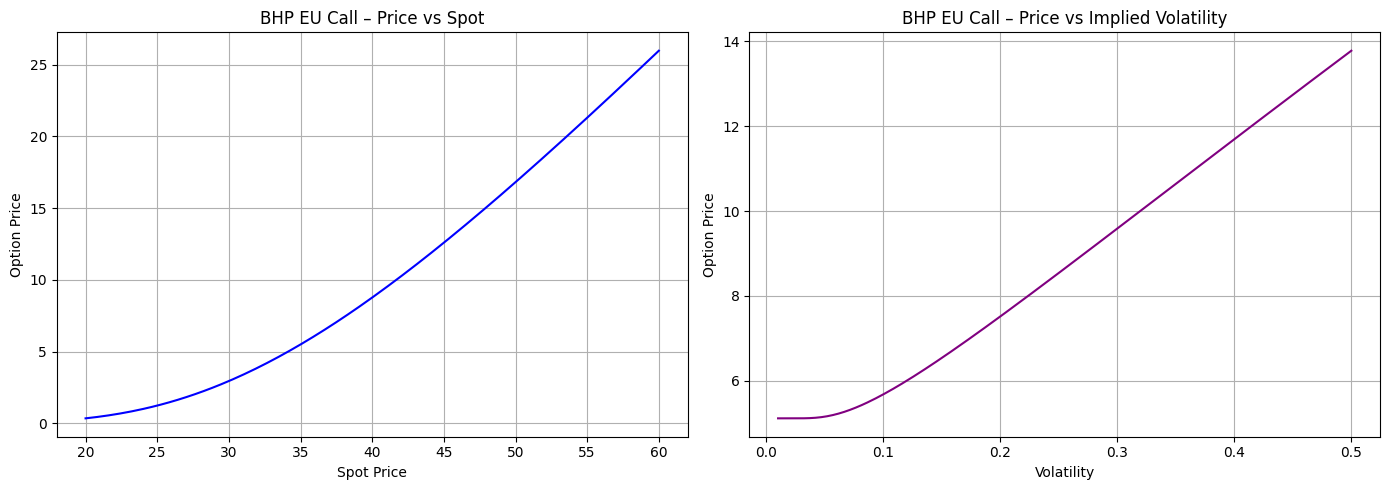

In [45]:
from sensitivity_visualiser import plot_spot_vol_sensitivity

plot_spot_vol_sensitivity(option_class=EuropeanOption, label = "BHP EU Call", base_spot=spot_bhp, base_vol=vol_bhp, spot_range=(20,60,200), vol_range=(0.01,0.5,200), ticker=ticker_bhp, strike=strike_bhp, expiry=expiry_bhp, rate=rate_bhp, option_type="call")

#Plotted graphs to visualise the sensitivity of the option price to spot and volatility changes

### Hedging Parameters

In [46]:
# Use HedgingCalculator to get delta, gamma, vega, theta, rho (extracted from Hedging_Parameters.py)

hc = HedgingCalculator()
greeks_bhp = hc.get_all_greeks(bhp_option, method="fd")

print("Greeks for BHP Option:")
for greek, value in greeks_bhp.items():
    print(f"{greek}: {value}")





Greeks for BHP Option:
delta: 0.5540012875086457
gamma: 0.022686599944638175
vega: 0.2099772020170996
theta: -0.9778740472898051
rho: 0.37288116959039996


### Hedging Strategy

In [47]:
# Near-the-money option
strike_bhp_ntmo = spot_bhp
expiry_bhp_ntmo = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15)) # 2.33 Years
rate_bhp_ntmo = yc.get_zero_rate(expiry_bhp_ntmo)
bhp_option_ntmo = EuropeanOption(ticker=ticker_bhp, spot=spot_bhp, strike=strike_bhp_ntmo, expiry=expiry_bhp_ntmo, rate=rate_bhp_ntmo, vol=vol_bhp, option_type="call", dividend_yield=dividend_yield_bhp)

delta_ntmo = hc.calculate_delta_fd(bhp_option_ntmo)
gamma_ntmo = hc.calculate_gamma_fd(bhp_option_ntmo)
vega_ntmo = hc.calculate_vega_fd(bhp_option_ntmo)
rho_ntmo = hc.calculate_rho_fd(bhp_option_ntmo)

# Out-the-money option
strike_bhp_otmo = 0.9 * spot_bhp
expiry_bhp_otmo = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15)) # 2.33 Years
rate_bhp_otmo = yc.get_zero_rate(expiry_bhp_otmo)
bhp_option_otmo = EuropeanOption(ticker=ticker_bhp, spot=spot_bhp, strike=strike_bhp_otmo, expiry=expiry_bhp_otmo, rate=rate_bhp_otmo, vol=vol_bhp, option_type="call", dividend_yield=dividend_yield_bhp)

delta_otmo = hc.calculate_delta_fd(bhp_option_otmo)
gamma_otmo = hc.calculate_gamma_fd(bhp_option_otmo)
vega_otmo = hc.calculate_vega_fd(bhp_option_otmo)
rho_otmo = hc.calculate_rho_fd(bhp_option_otmo)

hedges = {
    "Underlying Stock": {"Delta": 1, "Gamma": 0, "Vega": 0, "Rho": 0},
    "Near-the-Money Option": {"Delta": delta_ntmo, "Gamma": gamma_ntmo, "Vega": vega_ntmo, "Rho": rho_ntmo},
    "Out-the-Money Option": {"Delta": delta_otmo, "Gamma": gamma_otmo, "Vega": vega_otmo, "Rho": rho_otmo},
}

# Create a hedge matrix
hedge_matrix = pd.DataFrame(hedges).T

print("Hedge Matrix:")
print(hedge_matrix)

# Calculate the current Greeks of the BHP option
delta = hc.calculate_delta_fd(bhp_option)
gamma = hc.calculate_gamma_fd(bhp_option)
vega = hc.calculate_vega_fd(bhp_option)
rho = hc.calculate_rho_fd(bhp_option)

# Define the current Greeks of the BHP option
bhp_greeks = np.array([
    hc.calculate_delta_fd(bhp_option),
    hc.calculate_gamma_fd(bhp_option),
    hc.calculate_vega_fd(bhp_option),
    hc.calculate_rho_fd(bhp_option)
])

# Define the optimization function
def objective(weights):
    hedge_effect = hedge_matrix.values.T @ weights
    return np.linalg.norm(hedge_effect + bhp_greeks)  # Minimize the difference

# Initial guess (equal weights)
initial_weights = np.ones(len(hedge_matrix)) / len(hedge_matrix)

# Solve for optimal hedge weights
result = minimize(objective, initial_weights)

# Display results
optimal_weights = result.x
hedge_allocations = pd.DataFrame({"Instrument": hedge_matrix.index, "Optimal Weight": optimal_weights})
print("\nOptimal Hedge Allocations:")
print(hedge_allocations.round(4))

# Visualize the new greeks after hedging
minimized_greeks = hedge_matrix.values.T @ optimal_weights + bhp_greeks

greek_names = ["Delta", "Gamma", "Vega", "Rho"]
greek_matrix = pd.DataFrame({
    "Original BHP Option": bhp_greeks,
    "Post-Hedging (Minimized)": minimized_greeks
}, index=greek_names)

print("\nGreek Neutralization Result:")
print(greek_matrix.round(4))

Hedge Matrix:
                          Delta     Gamma      Vega       Rho
Underlying Stock       1.000000  0.000000  0.000000  0.000000
Near-the-Money Option  0.535676  0.023000  0.212882  0.363317
Out-the-Money Option   0.627719  0.020772  0.192223  0.407952

Optimal Hedge Allocations:
              Instrument  Optimal Weight
0       Underlying Stock          0.0005
1  Near-the-Money Option         -0.8222
2   Out-the-Money Option         -0.1818

Greek Neutralization Result:
       Original BHP Option  Post-Hedging (Minimized)
Delta               0.5540                      -0.0
Gamma               0.0227                       0.0
Vega                0.2100                       0.0
Rho                 0.3729                      -0.0


### Design and Model Justification

The Black-Scholes model was implemented to value the long European call on BHP as it is well-suited to the trade structure as it can only be exercised at expiry. The above market data sourced from Bloomberg ensured an accurate and credible valuation while resembling correct industry practice. Bloomberg volatilities were further used as they reflect real-time pricing from traded options, which is critical for aligning our valuation with how the market is actually pricing risk. The dividend yield was also included because when a company pays dividends, its share price typically drops. This lowers the expected future price of the stock, which reduces the value of the call option. With this data, a clear and accurate option value was determined that offers the counterparty leveraged upside with limited downside, while the bank collects the premium. Furthermore, the model used computed precise risk sensitivities (Greeks), which were used to construct a multi-instrument hedge that was then optimised to reduce exposure to key risks such as delta, vega, gamma and rho. Overall, this approach ensures pricing accuracy and effective risk control where every design and model choice were justified based on the option's characteristics and real market conditions.

## Trade 2: CBA American Put

The below trade is a long American put option on Commonwealth Bank of Australia Ltd (CBA), struck at 170.00 and expiring on 15 May 2026. As the bank selling this option to clients, we have valued it using a binomial tree model to account for the early exercise feature. The valuation is based on market data as of 16 May 2025, including a spot price of 169.66, implied volatility of 19.11%, and a risk-free rate of 2.66%. This structure enables us to offer clients downside protection and early exercise flexibility, while ensuring the price is market-consistent. The model also allows the bank to compute risk sensitivities and construct an appropriate hedge to manage our exposure over the one-year horizon.

### Market Data

In [48]:
ticker_cba = "CBA.AX"
date = "2025-05-16"

spot_cba = get_close_price(ticker_cba, date)
vol_cba = 0.19108
strike_cba = 170.00
dividend_yield_cba = 0.02867  

def time_to_expiry(start, end):
    return (end - start).days / 365.0

expiry_cba = time_to_expiry(datetime(2025, 5, 16), datetime(2026, 5, 15)) # 1 Year


print(f"Spot Price: {spot_cba:.4f}, Volatility: {vol_cba:.4f}, Strike Price: {strike_cba:.4f}, Expiry: {expiry_cba:.4f} years")

[*********************100%***********************]  1 of 1 completed

Spot Price: 169.6600, Volatility: 0.1911, Strike Price: 170.0000, Expiry: 0.9973 years


### Discount Rate

In [49]:
# Instantiate and price the option
rate_cba = yc.get_zero_rate(expiry_cba)
print(f"Rate for CBA Option: {rate_cba:.4%}")

Rate for CBA Option: 2.6061%


### Valuation

In [50]:
# Instantiate and price the option 
cba_option = AmericanPutOption(ticker=ticker_cba, spot=spot_cba, strike=strike_cba, expiry=expiry_cba, rate=rate_cba, vol=vol_cba, option_type="put", steps=100, dividend_yield=dividend_yield_cba)
print(f"Option Price: {cba_option.price():.4f}")

Option Price: 12.9684


### Visualisation

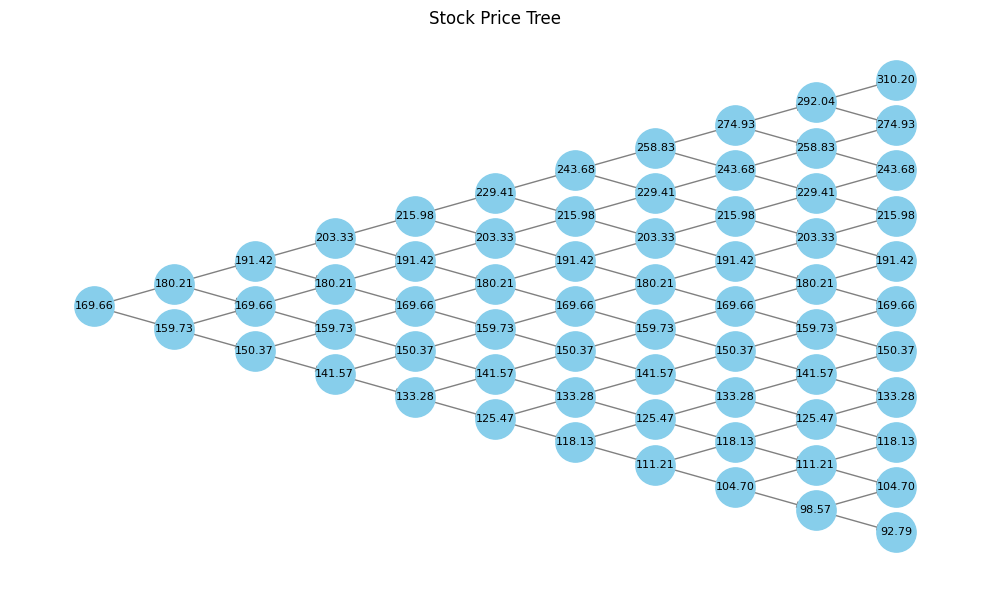

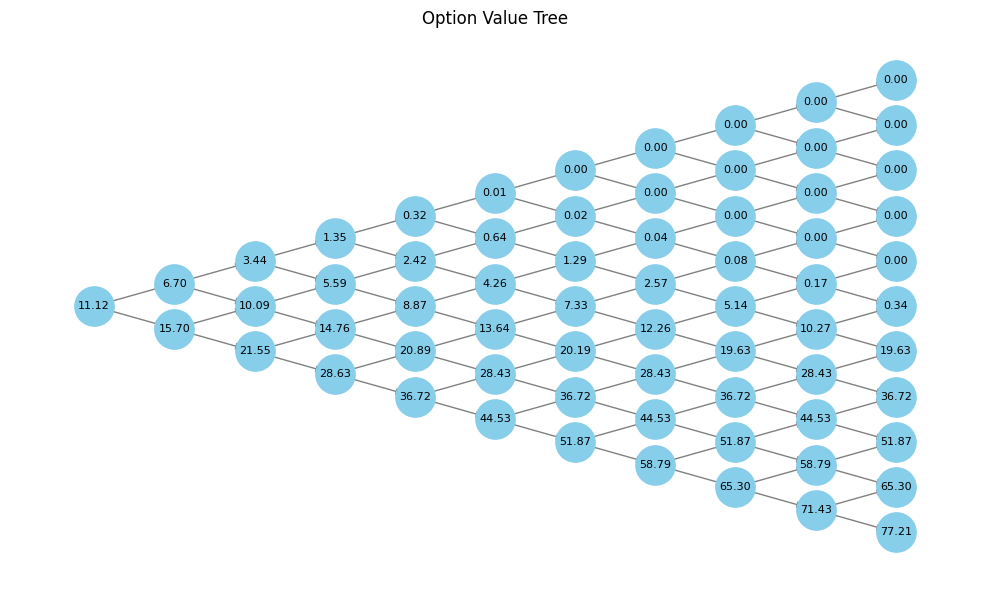

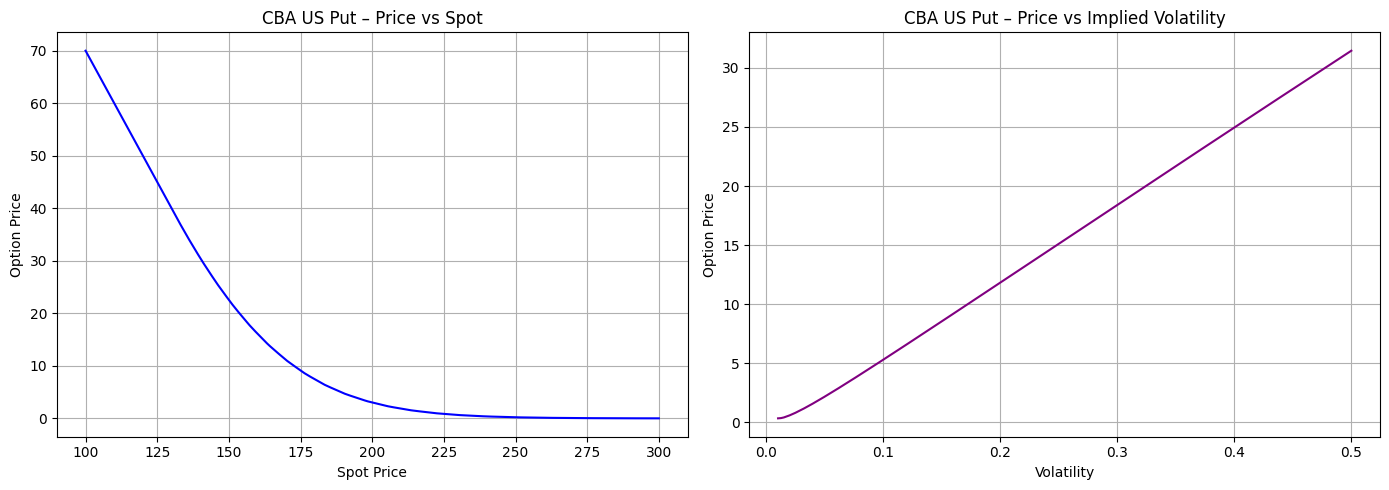

In [53]:
from tree_visualiser import get_stock_and_option_trees, plot_binomial_tree_networkx

stock_tree, option_tree = get_stock_and_option_trees(spot=spot_cba, strike=strike_cba, expiry=expiry_cba, rate=rate_cba, vol=vol_cba, steps=10)

plot_binomial_tree_networkx(stock_tree, title="Stock Price Tree")
plot_binomial_tree_networkx(option_tree, title="Option Value Tree")



plot_spot_vol_sensitivity(option_class=AmericanPutOption, label = "CBA US Put", base_spot=spot_cba, base_vol=vol_cba, spot_range=(100,300,200), vol_range=(0.01,0.5,200), ticker=ticker_cba, strike=strike_cba, expiry=expiry_cba, rate=rate_cba, option_type="put")




### Hedging Parameters

In [17]:
# Use HedgingCalculator to get delta, gamma, vega, theta, rho (extracted from Hedging_Parameters.py)
hc = HedgingCalculator()
greeks_cba = hc.get_all_greeks(cba_option, method="fd")

print("Greeks for CBA Option:")
for greek, value in greeks_cba.items():
    print(f"{greek}: {value:.4f}")

Greeks for CBA Option:
delta: -0.4700
gamma: 0.0503
vega: 0.6572
theta: -6.1755
rho: -0.7844


### Hedging Strategy

In [18]:
# Near-the-money option
strike_cba_ntmo = spot_cba
expiry_cba_ntmo = time_to_expiry(datetime(2025, 5, 16), datetime(2026, 5, 15)) # 1 Year
rate_cba_ntmo = yc.get_zero_rate(expiry_cba_ntmo)
cba_option_ntmo = AmericanPutOption(ticker=ticker_cba, spot=spot_cba, strike=strike_cba_ntmo, expiry=expiry_cba_ntmo, rate=rate_cba_ntmo, vol=vol_cba, option_type="put", dividend_yield=dividend_yield_cba)

delta_ntmo = hc.calculate_delta_fd(cba_option_ntmo)
gamma_ntmo = hc.calculate_gamma_fd(cba_option_ntmo)
vega_ntmo = hc.calculate_vega_fd(cba_option_ntmo)
rho_ntmo = hc.calculate_rho_fd(cba_option_ntmo)

# Out-the-money option
strike_cba_otmo = 185.00
expiry_cba_otmo = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15)) # 1 Year
rate_cba_otmo = yc.get_zero_rate(expiry_cba_otmo)
cba_option_otmo = AmericanPutOption(ticker=ticker_cba, spot=spot_cba, strike=strike_cba_otmo, expiry=expiry_cba_otmo, rate=rate_cba_otmo, vol=vol_cba, option_type="put", dividend_yield=dividend_yield_cba)

delta_otmo = hc.calculate_delta_fd(cba_option_otmo)
gamma_otmo = hc.calculate_gamma_fd(cba_option_otmo)
vega_otmo = hc.calculate_vega_fd(cba_option_otmo)
rho_otmo = hc.calculate_rho_fd(cba_option_otmo)

# Short-term option
strike_cba_st = 170.00
expiry_cba_st = time_to_expiry(datetime(2025, 5, 16), datetime(2025, 8, 15)) # 3 Months
rate_cba_st = yc.get_zero_rate(expiry_cba_st)
cba_option_st = AmericanPutOption(ticker=ticker_cba, spot=spot_cba, strike=strike_cba_st, expiry=expiry_cba_st, rate=rate_cba_st, vol=vol_cba, option_type="put", dividend_yield=dividend_yield_cba)

delta_st = hc.calculate_delta_fd(cba_option_st)
gamma_st = hc.calculate_gamma_fd(cba_option_st)
vega_st = hc.calculate_vega_fd(cba_option_st)
rho_st = hc.calculate_rho_fd(cba_option_st)

hedges = {
    "Underlying Stock": {"Delta": 1, "Gamma": 0, "Vega": 0, "Rho": 0},
    "Near-the-Money Option": {"Delta": delta_ntmo, "Gamma": gamma_ntmo, "Vega": vega_ntmo, "Rho": rho_ntmo},
    "Out-the-Money Option": {"Delta": delta_otmo, "Gamma": gamma_otmo, "Vega": vega_otmo, "Rho": rho_otmo},
    "Short-Term Option": {"Delta": delta_st, "Gamma": gamma_st, "Vega": vega_st, "Rho": rho_st},
}

# Create a hedge matrix
hedge_matrix = pd.DataFrame(hedges).T

print("Hedge Matrix:")
print(hedge_matrix)

# Calculate the current Greeks of the CBA option
delta = hc.calculate_delta_fd(cba_option)
gamma = hc.calculate_gamma_fd(cba_option)
vega = hc.calculate_vega_fd(cba_option)
rho = hc.calculate_rho_fd(cba_option)

# Define the current Greeks of the CBA option
cba_greeks = np.array([
    hc.calculate_delta_fd(cba_option),
    hc.calculate_gamma_fd(cba_option),
    hc.calculate_vega_fd(cba_option),
    hc.calculate_rho_fd(cba_option)
])

# Define the optimization function
def objective(weights):
    hedge_effect = hedge_matrix.values.T @ weights
    return np.linalg.norm(hedge_effect + cba_greeks)  # Minimize the difference

# Initial guess (equal weights)
initial_weights = np.ones(len(hedge_matrix)) / len(hedge_matrix)

# Solve for optimal hedge weights
result = minimize(objective, initial_weights)

# Display results
optimal_weights = result.x
hedge_allocations = pd.DataFrame({"Instrument": hedge_matrix.index, "Optimal Weight": optimal_weights})
print("\nOptimal Hedge Allocations:")
print(hedge_allocations.round(4))

# Visualize the new Greeks after hedging
minimized_greeks = hedge_matrix.values.T @ optimal_weights + cba_greeks

greek_names = ["Delta", "Gamma", "Vega", "Rho"]
greek_matrix = pd.DataFrame({
    "Original CBA Option": cba_greeks,
    "Post-Hedging (Minimized)": minimized_greeks
}, index=greek_names)

print("\nGreek Neutralization Result:")
print(greek_matrix.round(4))

Hedge Matrix:
                          Delta     Gamma      Vega       Rho
Underlying Stock       1.000000  0.000000  0.000000  0.000000
Near-the-Money Option -0.457013  0.076185  0.656608 -0.777192
Out-the-Money Option  -0.536603  0.006311  0.941001 -1.442725
Short-Term Option     -0.485393  0.049427  0.334677 -0.182444

Optimal Hedge Allocations:
              Instrument  Optimal Weight
0       Underlying Stock         -0.0597
1  Near-the-Money Option         -0.3590
2   Out-the-Money Option         -0.2965
3      Short-Term Option         -0.4256

Greek Neutralization Result:
       Original CBA Option  Post-Hedging (Minimized)
Delta              -0.4700                      -0.0
Gamma               0.0503                       0.0
Vega                0.6572                      -0.0
Rho                -0.7844                      -0.0


### Design and Model Justification

The binomial tree model was implemented to value the long American put on CBA as it accurately captures early exercise opportunities, a critical component of American options. Unlike the Black-Scholes model, the binomial approach allows for exercise prior to expiry by evaluating the optimal payoff at every node in the tree. This enables accurate pricing of the option while providing the client with downside protection and flexibility, in exchange for a premium.  Just as the Black-Scholes model, to manage risk, the model produced full Greek sensitives to construct a multi-instrument hedge matrix where the resulting portfolio achieved full Greek neutralisation showcasing that the risk profile was optimally controlled. In summary, the model design, parameter choices, and hedging strategy were all critically tailored to the American put’s unique features to further ensure both pricing accuracy and effective market-aligned risk management.

## Trade 3: WES Barrier Call

The below trade is a long up-and-in European barrier call option on Wesfarmers Ltd (WES), struck at 80.00 with a barrier level of 100.00 and expiring on 15 September 2027. The option is valued using a Monte Carlo simulation with 10,000 simulated paths. The model estimates a fair value of 11.97 based on market conditions as of 16 May 2025, including a spot price of 82.56, dividend yield of 2.08% and a risk-free interest rate of 5.03%. This structure allows the bank to provide clients with leveraged upside exposure to WES.  However, this exposure is conditional on the barrier being breached, while the bank collects a premium and manages risk using model-derived sensitivities.

### Market Data

In [54]:
ticker_wes = "WES.AX"
date = "2025-05-16"

spot_wes = get_close_price(ticker_wes, date) 
vol_wes = 0.18862
strike_wes = 80
barrier_wes = 100
dividend_yield_wes = 0.02762

def time_to_expiry(start, end):
    return (end - start).days / 365.0

expiry_wes = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15)) # 2.33 Years

print(f"Spot Price: {spot_wes:.4f}, Volatility: {vol_wes:.4f}, Strike Price: {strike_wes:.4f}, Expiry: {expiry_wes:.4f} years, Barrier: {barrier_wes:.4f}")

[*********************100%***********************]  1 of 1 completed

Spot Price: 82.5600, Volatility: 0.1886, Strike Price: 80.0000, Expiry: 2.3342 years, Barrier: 100.0000


### Discount Rate

In [55]:
rate_wes = yc.get_zero_rate(expiry_wes) 
print(f"Rate for WES Option: {rate_wes:.4%}")

Rate for WES Option: 5.0330%


### Valuation

In [56]:
# Instantiate and price the option 
wes_option = UpAndInCallOption(ticker=ticker_wes, spot=spot_wes, strike=strike_wes, expiry=expiry_wes, rate=rate_wes, vol=vol_wes, barrier=barrier_wes, simulations=1000, steps=252, dividend_yield=dividend_yield_wes)
print(f"Option Price: ${wes_option.price():.4f}")

Option Price: $11.6574


### Visualisation

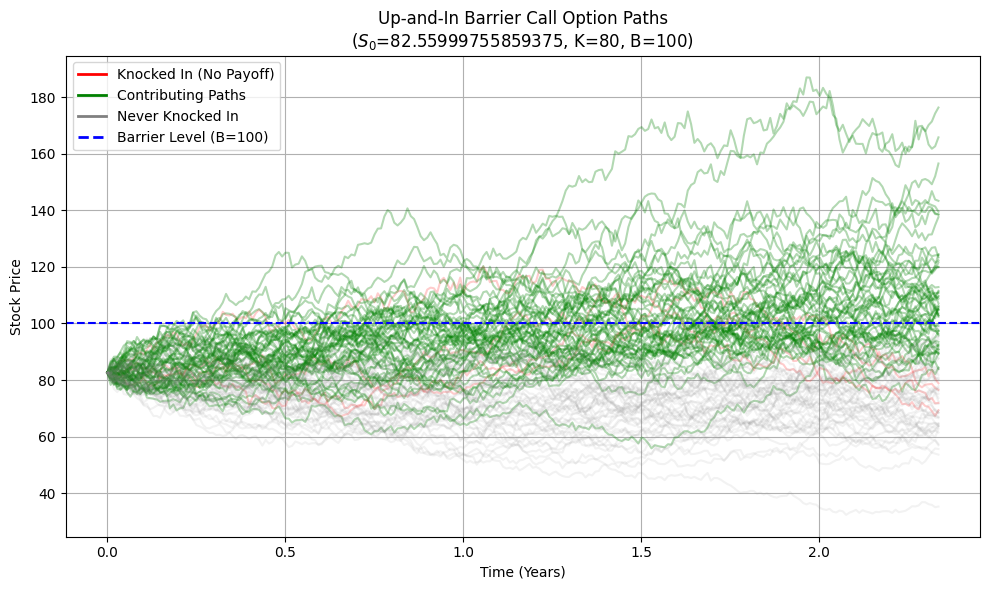

In [ ]:
# Graph for visualisation purposes. Option pricing conducts more simulations (10k, compared to the graph)

import sensitivity_visualiser
importlib.reload(sensitivity_visualiser)
from sensitivity_visualiser import visualize_up_and_in_barrier_call

visualize_up_and_in_barrier_call(
    S0=spot_wes,
    K=strike_wes,
    T=expiry_wes,
    r=rate_wes,
    sigma=vol_wes,
    B=barrier_wes,
    M=100,
    steps=252
)

plot_spot_vol_sensitivity_barrier(
    label="Barrier Call Test",
    base_spot=spot_wes,
    base_vol=vol_wes,
    strike=strike_wes,
    expiry=expiry_wes,
    rate=rate_bhp,
    option_type="call",
    ticker=ticker_wes,
    barrier=100,
    spot_range=(70, 100, 50),
    vol_range=(0.15, 0.4, 50)
)

# Plotted graph to simulate the Option Paths based on the Monte Carlo Simulation in visualise.py



### Hedging Parameters

In [19]:
# Use HedgingCalculator to get delta, gamma, vega, theta, rho (extracted from Hedging_Parameters.py)
hc = HedgingCalculator()
greeks_wes = hc.get_all_greeks(wes_option, method="fd")

print("Greeks for WES Option:")
for greek, value in greeks_wes.items():
    print(f"{greek}: {value:.4f}")


delta_wes = greeks_wes["delta"]
gamma_wes = greeks_wes["gamma"]
vega_wes = greeks_wes["vega"]
rho_wes = greeks_wes["rho"]

Greeks for WES Option:
delta: 0.8102
gamma: -0.2223
vega: 2.0869
theta: 34.6913
rho: 14.0320


### Hedging Strategy

In [23]:
# Near-the-money barrier call (strike = spot)
strike_wes_ntmo = spot_wes
expiry_wes_ntmo = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15))  # 2.33 Years
rate_wes_ntmo = yc.get_zero_rate(expiry_wes_ntmo)
wes_option_ntmo = UpAndInCallOption(
    ticker=ticker_wes,
    spot=spot_wes,
    strike=strike_wes_ntmo,
    expiry=expiry_wes_ntmo,
    rate=rate_wes_ntmo,
    vol=vol_wes,
    barrier=barrier_wes,
    simulations=10000,
    steps=252,
    dividend_yield=dividend_yield_wes
)

# Out-the-money barrier call (e.g. strike 10% above spot)
strike_wes_otmo = 1.10 * spot_wes
expiry_wes_otmo = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15))  # 2.33 Years
rate_wes_otmo = yc.get_zero_rate(expiry_wes_otmo)
wes_option_otmo = UpAndInCallOption(
    ticker=ticker_wes,
    spot=spot_wes,
    strike=strike_wes_otmo,
    expiry=expiry_wes_otmo,
    rate=rate_wes_otmo,
    vol=vol_wes,
    barrier=barrier_wes,
    simulations=10000,
    steps=252,
    dividend_yield=dividend_yield_wes
)

# Short-term barrier call
strike_wes_st = spot_wes
expiry_wes_st = time_to_expiry(datetime(2025, 5, 16), datetime(2025, 8, 15))  # 3 Months
rate_wes_st = yc.get_zero_rate(expiry_wes_st)
wes_option_st = UpAndInCallOption(
    ticker=ticker_wes,
    spot=spot_wes,
    strike=strike_wes_st,
    expiry=expiry_wes_st,
    rate=rate_wes_st,
    vol=vol_wes,
    barrier=barrier_wes,
    simulations=10000,
    steps=252,
    dividend_yield=dividend_yield_wes
)

# Calculate Greeks for hedges
delta_ntmo = hc.calculate_delta_fd(wes_option_ntmo)
gamma_ntmo = hc.calculate_gamma_fd(wes_option_ntmo)
vega_ntmo = hc.calculate_vega_fd(wes_option_ntmo)
rho_ntmo = hc.calculate_rho_fd(wes_option_ntmo)

delta_otmo = hc.calculate_delta_fd(wes_option_otmo)
gamma_otmo = hc.calculate_gamma_fd(wes_option_otmo)
vega_otmo = hc.calculate_vega_fd(wes_option_otmo)
rho_otmo = hc.calculate_rho_fd(wes_option_otmo)

delta_st = hc.calculate_delta_fd(wes_option_st)
gamma_st = hc.calculate_gamma_fd(wes_option_st)
vega_st = hc.calculate_vega_fd(wes_option_st)
rho_st = hc.calculate_rho_fd(wes_option_st)

hedges = {
    "Underlying Stock": {"Delta": 1, "Gamma": 0, "Vega": 0, "Rho": 0},
    "Near-the-Money Barrier Call": {"Delta": delta_ntmo, "Gamma": gamma_ntmo, "Vega": vega_ntmo, "Rho": rho_ntmo},
    "Out-the-Money Barrier Call": {"Delta": delta_otmo, "Gamma": gamma_otmo, "Vega": vega_otmo, "Rho": rho_otmo},
    "Short-Term Barrier Call": {"Delta": delta_st, "Gamma": gamma_st, "Vega": vega_st, "Rho": rho_st},
}

hedge_matrix = pd.DataFrame(hedges).T
print("Hedge Matrix:")
print(hedge_matrix)


wes_greeks = np.array([delta_wes, gamma_wes, vega_wes, rho_wes])

# Optimization
def objective(weights):
    hedge_effect = hedge_matrix.values.T @ weights
    return np.linalg.norm(hedge_effect + wes_greeks)

initial_weights = np.ones(len(hedge_matrix)) / len(hedge_matrix)
result = minimize(objective, initial_weights)
optimal_weights = result.x

hedge_allocations = pd.DataFrame({
    "Instrument": hedge_matrix.index,
    "Optimal Weight": optimal_weights
})

print("\nOptimal Hedge Allocations:")
print(hedge_allocations.round(4))

minimized_greeks = hedge_matrix.values.T @ optimal_weights + wes_greeks
greek_names = ["Delta", "Gamma", "Vega", "Rho"]

greek_matrix = pd.DataFrame({
    "Original WES Barrier Option": wes_greeks,
    "Post-Hedging (Minimized)": minimized_greeks
}, index=greek_names)

print("\nGreek Neutralization Result:")
print(greek_matrix.round(4))

KeyboardInterrupt: 

### Design and Model Justification

The Monte Carlo simulation model was implemented to value the up-and-in European barrier call on Wesfarmers Ltd (WES). This is due to the model’s path-dependent nature which makes it unsuitable for closed-form solutions such as Black-Scholes. The option will only become active if the underlying breaches the 100.00 barrier where upon activation the option behaves like a standard European call with a strike of 80.00, expiring in September 2027. The simulation conducted used 10,000 paths to achieve a practical trade-off between pricing accuracy and computational speed. A higher number of paths improves precision which is especially important for barrier options where knock-in probability depends heavily on how frequently the price path is sampled. Hence, 10,000 paths was found as a justified middle ground between accuracy and time taken on processing efficiency.  Just as the other models, risk sensitivities (Greeks) were calculated using finite-difference models and a multi-instrument hedge was constructed. Overall, the design choices reflect the bank’s objective of pricing accuracy and risk control in line with market conditions, while offering clients leveraged upside exposure in exchange for premium income.

## Trade 4: Basket Call

The below trade is a European type of basket call option written by the bank with a strike price of 175.00 and expiring on 17 July 2025. The underlying is a weighted basket of four ASX listed stocks including 10% BHP Group Ltd (BHP), 35% CSL Limited (CSL), 15% Woolside Energy Group (WDS) and 40% Macquarie Group Ltd (MQG). The option is valued using a basket-adapted Black-Scholes model based on market data as of 16 May 2025, which includes a basket spot level of 175.96, individual implied volatilities between 18% and 26%, a risk free rate of 3.80% and a weighted dividend yield of 4.43%. This trade allows the client to benefit from any appreciation in the basket’s value above the strike, while the bank is obligated to pay the resulting payoff at expiry. The model ensures pricing consistency and supports the bank’s ability to hedge exposure through component-level risk sensitivities.

### Market Data

In [31]:
# Basket Call Option Inputs
tickers_basket = ["BHP.AX", "CSL.AX", "WDS.AX", "MQG.AX"]
date = "2025-05-16"
spot = {ticker: get_close_price(ticker, date) for ticker in tickers_basket}
vol = np.array([0.22273, 0.21718, 0.27481, 0.21907]) #IV's collected from bloomberg
weights = np.array([0.10, 0.35, 0.15, 0.40])
spot_basket = [spot[t] for t in tickers_basket]

# build basket_vol
# Input correlation matrix (acquired from bloomberg)
correlation_matrix = np.array([
    [1.000, 0.188, 0.416, 0.283], # BHP
    [0.188, 1.000, 0.199, 0.390], # CSL
    [0.416, 0.199, 1.000, 0.365], # WDS
    [0.283, 0.390, 0.365, 1.000], # MDQ
])

# Build covariance matrix
cov_matrix = np.outer(vol, vol) * correlation_matrix

# Calculate Basket Voltaiity
basket_variance = weights @ cov_matrix @ weights
vol_basket = np.sqrt(basket_variance)
strike_basket = 175.0
dividend_yield_basket = 0.044268  #weighted average of asset div yields taken from Bloomberg

from datetime import datetime
expiry_basket = time_to_expiry(datetime(2025, 5, 16), datetime(2025, 7, 17))

print("Spot prices:", spot_basket)
print("Volatilities:", vol_basket)
print(f"Strike: {strike_basket}, Expiry: {expiry_basket:.2f} yrs")
print(correlation_matrix)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Spot prices: [39.720001220703125, 241.82000732421875, 21.920000076293945, 207.35000610351562]
Volatilities: 0.16503490871334767
Strike: 175.0, Expiry: 0.17 yrs
[[1.    0.188 0.416 0.283]
 [0.188 1.    0.199 0.39 ]
 [0.416 0.199 1.    0.365]
 [0.283 0.39  0.365 1.   ]]


### Discount Rate

In [26]:
rate_basket = yc.get_zero_rate(expiry_basket)
print(f"Discount Rate for Basket Option: {rate_basket:.4%}")

Discount Rate for Basket Option: 3.7980%


### Valuation

In [30]:
# Price the option 
basket_option = BasketCallOption(tickers=tickers_basket, spot_prices=spot_basket, weights=weights, strike=strike_basket, expiry=expiry_basket, rate=rate_basket, vol=vol_basket, corr_matrix=correlation_matrix, dividend_yield=dividend_yield_basket)
print(f"Basket Option Price: ${basket_option.price():.4f}")

Basket Option Price: $3.2833


### Visualisation

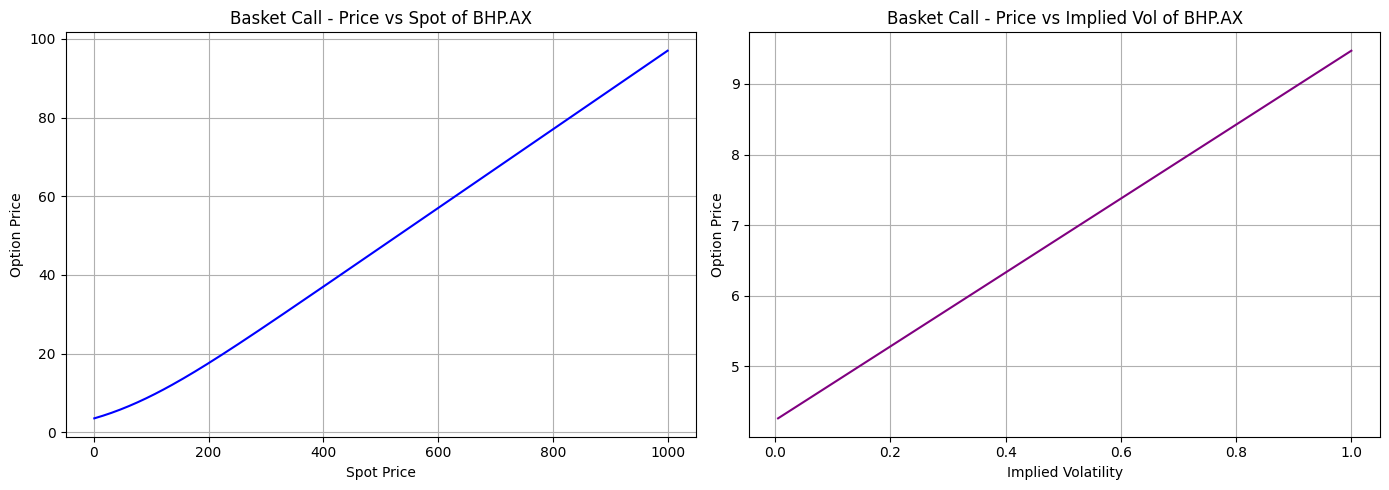

In [ ]:
plot_spot_vol_sensitivity_basket_bs(
    label="Basket Call",
    base_spots=spot_basket,
    base_vols=vol,
    weights=weights,
    corr_matrix=correlation_matrix,
    strike=strike_basket,
    expiry=expiry_basket,
    rate=rate_basket,
    ticker="Basket",
    tickers=tickers_basket,
    component_index=0, # 0 = BHP, 1 = CSL, 2 = WDS, 3 = MQG
    spot_range=(1, 1000, 200),
    vol_range=(0.005, 1, 40),
    option_class=BasketCallOption
)
#plotted graph to visualise the sensitivity of the basket option price to spot and volatility changes. Changing the component changes the ticker. E.g. 1 will show you how a change in the spot CSL
# will will affect the option price. 

### Hedging Parameters

In [ ]:
# Use HedgingCalculator to get delta, gamma, vega, theta, rho
hc = HedgingCalculator()
greeks_basket = hc.get_all_greeks(basket_option, method="fd")

print("Greeks for Basket Option:")
for greek, value in greeks_basket.items():
    if isinstance(value, (list, np.ndarray)):
        print(f"{greek}: {[round(float(v), 4) for v in value]}")
    else:
        print(f"{greek}: {value:.4f}")

NameError: name 'basket_option' is not defined

### Hedging Strategy

In [ ]:
# Near-the-money basket call
strike_basket_ntmo = np.dot(spot_basket, weights)
expiry_basket_ntmo = time_to_expiry(datetime(2025, 5, 16), datetime(2025, 7, 17))  # 2 Months
rate_basket_ntmo = yc.get_zero_rate(expiry_basket_ntmo)
basket_option_ntmo = BasketCallOption(
    tickers=tickers_basket,
    spot_prices=spot_basket,
    weights=weights,
    strike=strike_basket_ntmo,
    expiry=expiry_basket_ntmo,
    rate=rate_basket_ntmo,
    vol=vol_basket,
    corr_matrix=basket_corr,
    dividend_yield=dividend_yield_basket
)

# Out-the-money basket call
strike_basket_otmo = 1.10 * np.dot(spot_basket, weights)
expiry_basket_otmo = time_to_expiry(datetime(2025, 5, 16), datetime(2025, 7, 17))  # 2 Months
rate_basket_otmo = yc.get_zero_rate(expiry_basket_otmo)
basket_option_otmo = BasketCallOption(
    tickers=tickers_basket,
    spot_prices=spot_basket,
    weights=weights,
    strike=strike_basket_otmo,
    expiry=expiry_basket_otmo,
    rate=rate_basket_otmo,
    vol=vol_basket,
    corr_matrix=basket_corr,
    dividend_yield=dividend_yield_basket
)

# Long-term basket call
strike_basket_lt = np.dot(spot_basket, weights)
expiry_basket_lt = time_to_expiry(datetime(2025, 5, 16), datetime(2026, 5, 15))  # 1 Year
rate_basket_lt = yc.get_zero_rate(expiry_basket_lt)
basket_option_lt = BasketCallOption(
    tickers=tickers_basket,
    spot_prices=spot_basket,
    weights=weights,
    strike=strike_basket_lt,
    expiry=expiry_basket_lt,
    rate=rate_basket_lt,
    vol=vol_basket,
    corr_matrix=basket_corr,
    dividend_yield=dividend_yield_basket
)

# Calculate Greeks for hedging instruments
delta_ntmo = hc.calculate_delta_fd(basket_option_ntmo)
gamma_ntmo = hc.calculate_gamma_fd(basket_option_ntmo)
vega_ntmo = hc.calculate_vega_fd(basket_option_ntmo)
rho_ntmo = hc.calculate_rho_fd(basket_option_ntmo)

delta_otmo = hc.calculate_delta_fd(basket_option_otmo)
gamma_otmo = hc.calculate_gamma_fd(basket_option_otmo)
vega_otmo = hc.calculate_vega_fd(basket_option_otmo)
rho_otmo = hc.calculate_rho_fd(basket_option_otmo)

delta_lt = hc.calculate_delta_fd(basket_option_lt)
gamma_lt = hc.calculate_gamma_fd(basket_option_lt)
vega_lt = hc.calculate_vega_fd(basket_option_lt)
rho_lt = hc.calculate_rho_fd(basket_option_lt)

# Build hedge matrix
hedges = {
    "Underlying Basket": {"Delta": 1, "Gamma": 0, "Vega": 0, "Rho": 0},
    "Near-the-Money Basket Call": {"Delta": np.dot(delta_ntmo, weights), "Gamma": np.dot(gamma_ntmo, weights), "Vega": np.dot(vega_ntmo, weights), "Rho": rho_ntmo},
    "Out-the-Money Basket Call": {"Delta": np.dot(delta_otmo, weights), "Gamma": np.dot(gamma_otmo, weights), "Vega": np.dot(vega_otmo, weights), "Rho": rho_otmo},
    "Long-Term Basket Call": {"Delta": np.dot(delta_lt, weights), "Gamma": np.dot(gamma_lt, weights), "Vega": np.dot(vega_lt, weights), "Rho": rho_lt},
}

hedge_matrix = pd.DataFrame(hedges).T
print("Hedge Matrix:")
print(hedge_matrix)

# Calculate Greeks of the basket option
delta = hc.calculate_delta_fd(basket_option)
gamma = hc.calculate_gamma_fd(basket_option)
vega = hc.calculate_vega_fd(basket_option)
rho = hc.calculate_rho_fd(basket_option)

# Convert vector Greeks to scalars using basket weights
delta = np.dot(delta, weights)
gamma = np.dot(gamma, weights)
vega = np.dot(vega, weights)

basket_greeks = np.array([delta, gamma, vega, rho], dtype=float)

# Optimization
def objective(weights):
    weights = np.array(weights)
    hedge_effect = hedge_matrix.values.T @ weights
    return np.linalg.norm(hedge_effect + basket_greeks)

initial_weights = np.ones(len(hedge_matrix)) / len(hedge_matrix)
result = minimize(objective, initial_weights)
optimal_weights = result.x

hedge_allocations = pd.DataFrame({
    "Instrument": hedge_matrix.index,
    "Optimal Weight": optimal_weights
})

print("\nOptimal Hedge Allocations:")
print(hedge_allocations.round(4))

minimized_greeks = hedge_matrix.values.T @ optimal_weights + basket_greeks
greek_names = ["Delta", "Gamma", "Vega", "Rho"]

greek_matrix = pd.DataFrame({
    "Original Basket Call Option": basket_greeks,
    "Post-Hedging (Minimized)": minimized_greeks
}, index=greek_names)

print("\nGreek Neutralization Result:")
print(greek_matrix.round(4))

Hedge Matrix:
                               Delta     Gamma      Vega       Rho
Underlying Basket           1.000000  0.000000  0.000000  0.000000
Near-the-Money Basket Call  0.162084  0.002255  0.073485  0.139846
Out-the-Money Basket Call   0.065544  0.001629  0.053089  0.058090
Long-Term Basket Call       0.158878  0.000896  0.171437  0.713207

Optimal Hedge Allocations:
                   Instrument  Optimal Weight
0           Underlying Basket         -0.0000
1  Near-the-Money Basket Call         -0.9847
2   Out-the-Money Basket Call         -0.0215
3       Long-Term Basket Call         -0.0001

Greek Neutralization Result:
       Original Basket Call Option  Post-Hedging (Minimized)
Delta                       0.1610                       0.0
Gamma                       0.0023                       0.0
Vega                        0.0735                       0.0
Rho                         0.1390                       0.0


### Design and Model Justification (might remove)

The basket-adapted Black-Scholes model was implemented to value the European basket call option on a weighted portfolio of four ASX-listed stocks. This model is appropriate as the option can only be exercised at expiry and the underlying basket follows a smooth and predictable price path, allowing the use of average volatilities and correlations for pricing. Market data such as spot prices, ATM implied volatilities, dividend yields, and pairwise correlations was collected from Bloomberg and incorporated into the model. Using Bloomberg ensures high-quality, consistent, and market-aligned inputs which is critical for accurate valuation and risk management and resembles industry practice. A 60 day trading window was determined to estimate historical volatilities and correlations because it offers a practical balance between recency and reliability. It was deemed long enough to avoid short-term irregularities, coincidingly short enough to remain subject to current market conditions. The model produced a fair value for the basket call and quantified the counterparty’s leveraged upside, while the bank retains the obligation to pay any positive difference above the strike at maturity. Risk sensitivities (Greeks) were calculated using finite differences which were then used to construct a hedge using proxy basket options. The hedge was then optimised via least squares to minimise exposures to delta, gamma, vega, and rho. Overall, this approach delivers accurate pricing and risk control, with each modelling choice aligning with the trade’s features and current market conditions.

## Portfolio Valuation and Hedging Summary (might remove)

In [33]:
#summary of all greeks and prices for each option
descriptions = [
    "BHP European Call",
    "CBA American Put",
    "WES Up-and-In Barrier Call",
    "Basket European Call"
]
options = [
    bhp_option,
    cba_option,
    wes_option,
    basket_option
]

greeks_list = []
prices = []
for opt in options:
    hc = HedgingCalculator()
    greeks = hc.get_all_greeks(opt, method="fd")
    greeks_list.append(greeks)
    prices.append(opt.price())


greeks_df = pd.DataFrame(greeks_list, index=descriptions)
greeks_df["Price"] = prices
greeks_df = greeks_df[["Price", "delta", "gamma", "vega", "theta", "rho"]].round(4)

portfolio_summary = greeks_df.sum(axis=0).to_frame().T
portfolio_summary.index = ["Portfolio Total"]
portfolio_summary = portfolio_summary.round(4)

summary = pd.concat([greeks_df, portfolio_summary])
display(summary)

,Price,delta,gamma,vega,theta,rho
BHP European Call,6.0372,0.554001,0.022687,0.21,-0.9779,0.3729
CBA American Put,12.9684,-0.470044,0.050263,0.6572,-6.1755,-0.7844
WES Up-and-In Barrier Call,12.014,0.009053,-1.190993,-3.9009,15.3731,-4.5369
Basket European Call,3.2833,"[0.04902386732440789, 0.17158235102803587, 0.0...","[0.0004542270921490399, 0.005563597330990433, ...",0.2091,-9.2055,0.14
Portfolio Total,34.3029,"[0.14203368642607295, 0.26459217012970093, 0.1...","[-1.1175896832540282, -1.1124803130151868, -1....",-2.8246,-0.9858,-4.8084


## Conclusion

- Modular, OOP-driven pricing system
- Accurate pricing and hedging of diverse OTC trades
- Integration of real market data and theory